# Вычисление чисел Бетти

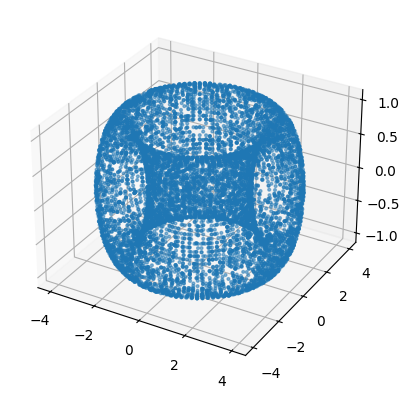

In [1]:
import mogutda
import math
from itertools import product
import networkx as nx
import random
from scipy.spatial import distance
from mogutda import VietorisRipsComplex
from mogutda import SimplicialComplex
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import os
from generate_topology_objects import *

#### Вспомогательные функции

In [2]:
def my_3d_draw(coordinates):
    fig = plt.figure(figsize=(6, 6), dpi=130)
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('x axis')
    ax.set_ylabel('y axis')
    ax.set_zlabel('z axis')
    lim = max([max(i) for i in coordinates])
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(-lim, lim)
    ax.set_box_aspect((1, 1, 1))
    if type(coordinates) != np.matrix:
        coordinates = np.matrix(coordinates)

    ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2], alpha=0.8, cmap=cm.Wistia)
    fig.savefig("torus.png", dpi=130, bbox_inches='tight', transparent=True)
    plt.show()


### Библиотечная функция

In [ ]:
my_S = VietorisRipsComplex([(0, 0), (0, 1), (1, 0), (1, 1)], 2)
for i in range(10):
    print(i, my_S.betti_number(i))

In [ ]:
my_S = VietorisRipsComplex([(0, 0), (0, 1), (1, 1), (1, 0)], 1.5)
my_S.draw()
for i in range(7):
    print(f"{i}-th betti number: {my_S.betti_number(i)}")

In [ ]:
S = VietorisRipsComplex([(0, 1), (1, 2), (2, 3), (3, 0), (0, 4), (4, 1), (1, 3), (4, 3)], 2.5)
S.draw()
for i in range(7):
    print(f"{i}-th betti number: {S.betti_number(i)}")

In [ ]:
torus = get_torus_points_evenly(2, 3, 80)
my_3d_draw(torus)
for e in range(10, 40, 1):
    eps = e / 10
    S = VietorisRipsComplex(torus, eps)
    print(eps, end=' | ')
    for n in range(3):
        print(S.betti_number(n), end=' ')
    print()


C:\Users\grish\AppData\Local\Temp\ipykernel_8492\210318836.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2], alpha=0.8, cmap=cm.Wistia)


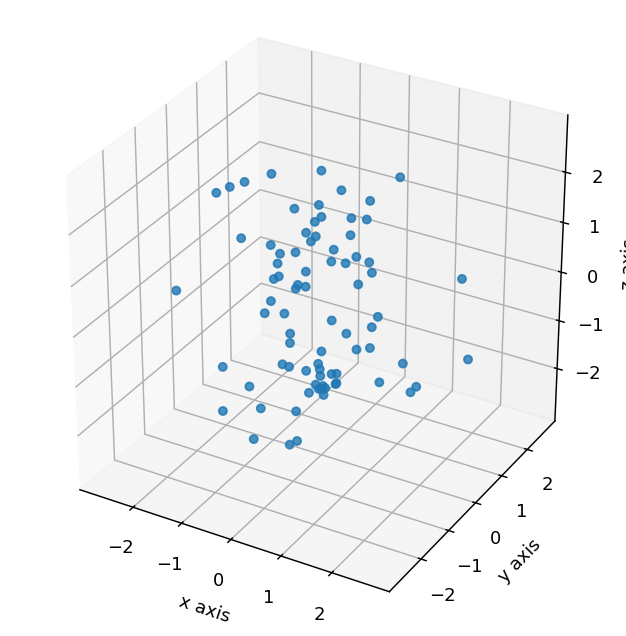

KeyboardInterrupt: 

In [3]:
torus = get_torus_points_evenly(2, 1, 80)
my_3d_draw(torus)
for eps in np.linspace(2, 6, 40):
    # eps = e / 10
    S = VietorisRipsComplex(torus, eps)
    # print(eps)
    b0 = S.betti_number(0)
    # if b0 != 1:
    #     print(eps, b0)
    b1 = S.betti_number(1)
    # if b1 != 2:
    #     print(eps, b0, b1)
    #     continue
    b2 = S.betti_number(2)
    # if b2 != 1:
    #     print(eps, b0, b1, b2)
    #     continue
    print(eps, '|', b0, b1, b2)
    # print('OK', eps, '|', b0, b1, b2)


### Числа Бетти алгоритмом из книги Эдельсбруннера и Харера

In [ ]:
class ComputingBetti:
    def __init__(self, vector_points, eps: float = 0):
        self.vector_points = vector_points
        self.eps = eps
        self.simplicial_complex = VietorisRipsComplex(self.vector_points, self.eps)
        self.all_subsets_SC = self._get_subsets()

    def _get_subsets(self) -> list:
        sets = []
        for simplex in self.simplicial_complex.face_set:
            len_s = len(simplex)
            for i in range(1 << len_s):
                subset = {simplex[bit] for bit in range(len_s) if i & (1 << bit)}
                if len(subset) and (subset not in sets):
                    sets.append(subset)
        for i in range(len(sets)):
            sets[i] = set(sets[i])
        return sets

    def rank_Z2(self, matrix: np.matrix) -> int:
        n, m = matrix.shape
        rk = 0
        for i in range(m):
            if rk == min(n, m):
                break
            k = matrix[rk:, i].argmax() + rk
            if matrix[k, i] == 0:
                continue
            if k != rk:
                matrix[[k, rk]] = matrix[[rk, k]]
                # for col in range(i, m):
                #     matrix[rk, col], matrix[k, col] = matrix[k, col], matrix[rk, col]
            for row in range(rk + 1, n):
                if matrix[row, i]:
                    for col in range(i, m):
                        matrix[row, col] ^= matrix[rk, col]
            rk += 1
        return rk

    def count_betti_number(self, n: int = 0) -> int:
        n += 1
        np1_comlexes_id = [i for i in range(len(self.all_subsets_SC)) if len(self.all_subsets_SC[i]) == (n + 1)]
        n_comlexes_id = [i for i in range(len(self.all_subsets_SC)) if len(self.all_subsets_SC[i]) == n]
        nm1_comlexes_id = [i for i in range(len(self.all_subsets_SC)) if len(self.all_subsets_SC[i]) == (n - 1)]
        cnt_np1 = len(np1_comlexes_id)
        cnt_n = len(n_comlexes_id)
        cnt_nm1 = len(nm1_comlexes_id)

        Z_p = 0
        B_p = 0

        if cnt_nm1 == 0:
            Z_p = cnt_n
        elif cnt_n != 0 and cnt_nm1 != 0:
            boundary_matrix = np.matrix(data=[[0] * cnt_n for _ in range(cnt_nm1)], dtype=bool)
            for i in range(cnt_nm1):
                for j in range(cnt_n):
                    if len(self.all_subsets_SC[nm1_comlexes_id[i]].intersection(
                            self.all_subsets_SC[n_comlexes_id[j]])) == n - 1:
                        boundary_matrix[i, j] = 1
            Z_p = cnt_n - self.rank_Z2(boundary_matrix)

        if cnt_n == 0:
            B_p = cnt_np1
        elif cnt_np1 != 0 and cnt_n != 0:
            boundary_matrix = np.matrix(data=[[0] * cnt_np1 for _ in range(cnt_n)], dtype=bool)
            # print(boundary_matrix)
            for i in range(cnt_n):
                for j in range(cnt_np1):
                    if len(self.all_subsets_SC[n_comlexes_id[i]].intersection(
                            self.all_subsets_SC[np1_comlexes_id[j]])) == n:
                        boundary_matrix[i, j] = 1
            B_p = self.rank_Z2(boundary_matrix)

        return Z_p - B_p

    def mogutda_betti(self, n: int = 0) -> int:
        return self.simplicial_complex.betti_number(n)

##### Примеры

In [ ]:
sphere = np.asarray(get_sphere_points(20, 3))
eps = 7
computing_betti = ComputingBetti(sphere, eps)
for n in range(5):
    print(n, computing_betti.count_betti_number(n), computing_betti.mogutda_betti(n))
my_3d_draw(sphere)
computing_betti.simplicial_complex.draw()

In [ ]:
vector_points = get_torus_points(2, 10)
eps = 7
computing_betti = ComputingBetti(vector_points, eps)
for n in range(5):
    print(n, computing_betti.count_betti_number(n), computing_betti.mogutda_betti(n))

my_3d_draw(vector_points)
computing_betti.simplicial_complex.draw()

In [ ]:
vector_points = [(0, 0), (0, 10), (10, 10), (10, 0)]
eps = 14
computing_betti = ComputingBetti(vector_points, eps)
for n in range(5):
    print(n, computing_betti.count_betti_number(n))

computing_betti.simplicial_complex.draw()

In [ ]:
vector_points = [(0, 0, 0), (0, 0, 1), (0, 1, 0), (1, 0, 0), (1, 1, 0), (1, 0, 1), (0, 1, 1), (1, 1, 1)]
eps = 2
computing_betti = ComputingBetti(vector_points, eps)
for n in range(5):
    print(n, computing_betti.count_betti_number(n))

computing_betti.simplicial_complex.draw()

In [ ]:
annulus_points = annulus(150)
computing_betti = ComputingBetti(annulus_points, 0.7)

In [ ]:
for n in range(5):
    print(n, computing_betti.mogutda_betti(n))

In [ ]:
computing_betti.simplicial_complex.draw()

In [ ]:
plt.scatter([i[0] for i in annulus_points], [i[1] for i in annulus_points])
plt.show()

In [ ]:
%timeit computing_betti.count_betti_number(1)
%timeit computing_betti.mogutda_betti(1)
%timeit computing_betti.count_betti_number(0)
%timeit computing_betti.mogutda_betti(0)

### Computing Betti for real Russian (just on words) (not working)

In [ ]:
rus_points = np.load('../SVD_embeddings/rus_100to2_tsne.npy', allow_pickle=True)[()]
eps_range = (math.dist(rus_points[i], rus_points[j]) for i in range(len(rus_points)) for j in
             range(i + 1, len(rus_points)))
eps = 1

In [ ]:
rus_complex = VietorisRipsComplex(rus_points, eps)

In [ ]:
betti_nums = rus_complex.get_betti_numbers()

In [ ]:
matrix = np.asarray([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [1, 1, 1, 0]])


In [ ]:
def gf2_rank(rows):
    rank = 0
    while rows.any():
        pivot_row = rows[0]
        rows = rows[1:, :]
        if pivot_row.any():
            low = 0
            for i in range(len(pivot_row)):
                if pivot_row[i]:
                    low = i
                    break
            rank += 1
            for index, row in enumerate(rows):
                if row[low]:
                    rows[index] = row ^ pivot_row
    return rank

In [ ]:
def rank_Z2(matrix: np.matrix) -> int:
    n, m = matrix.shape
    rk = 0
    for i in range(m):
        if rk == min(n, m):
            break
        k = matrix[rk:, i].argmax() + rk
        if matrix[k, i] == 0:
            continue
        if k != rk:
            for col in range(i, m):
                matrix[rk, col], matrix[k, col] = matrix[k, col], matrix[rk, col]
        for row in range(rk + 1, n):
            if matrix[row, i]:
                for col in range(i, m):
                    matrix[row, col] = matrix[row, col] ^ matrix[rk, col]
        rk += 1
    return rk

In [ ]:
gf2_rank(deepcopy(matrix))

In [ ]:
from copy import deepcopy
from timeit import timeit

In [ ]:
for i in range(50):
    matrix = np.random.choice(2, size=(random.randint(100, 200), random.randint(100, 200)))
    a = timeit(lambda: gf2_rank(deepcopy(matrix)), number=1)
    b = timeit(lambda: rank_Z2(np.matrix(matrix)), number=1)
    print(matrix.shape, b - a)
    if a > b:
        print(matrix.shape)
